# Gymnasium 基础教程：为值迭代和策略迭代准备环境

## 📖 为什么需要 Gymnasium？

在学习**贝尔曼最优公式**、**值迭代**和**策略迭代**时，我们需要一个简单、可控的环境来验证算法。Gymnasium 是强化学习的标准环境接口，让我们可以：

- 🎮 创建标准化的 MDP（马尔可夫决策过程）环境
- 🔄 轻松实现状态转移和奖励函数
- 📊 可视化智能体的学习过程
- ✅ 验证值迭代、策略迭代等算法的正确性

## 🎯 本教程目标

我们将从零开始创建一个**网格世界（GridWorld）环境**，这是学习动态规划算法的经典环境：

- **环境特性**：
  - 可自定义网格大小（如 5×5、10×10）
  - 随机初始化智能体和目标位置
  - 支持自定义奖励函数
  - 可设置障碍物（进阶功能）
  - 文本和图形可视化

- **学习路径**：
  1. 理解 Gymnasium 的核心概念
  2. 逐步构建自定义环境
  3. 测试和验证环境
  4. 为后续算法做准备

---

让我们开始吧！

## 第一步：安装和导入必要的库

In [1]:
# 首先安装 gymnasium（如果还没安装的话）
# !pip install gymnasium numpy matplotlib imageio

# 导入必要的库
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional, Tuple, Dict, Any, Annotated

# 设置 matplotlib 后端（必须在导入 pyplot 之前）
import matplotlib
matplotlib.use('Agg')  # 使用非交互式后端,适合生成图像文件

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output, Image as IPImage
import imageio
from io import BytesIO

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

print(f"✅ Gymnasium 版本: {gym.__version__}")
print(f"✅ NumPy 版本: {np.__version__}")
print(f"✅ Matplotlib 版本: {matplotlib.__version__}")
print(f"✅ Matplotlib 后端: {matplotlib.get_backend()}")
print(f"✅ 中文字体配置完成")
print(f"✅ imageio 已导入，支持 GIF 动画生成")

✅ Gymnasium 版本: 1.2.1
✅ NumPy 版本: 2.3.3
✅ Matplotlib 版本: 3.10.7
✅ Matplotlib 后端: Agg
✅ 中文字体配置完成
✅ imageio 已导入，支持 GIF 动画生成


## 第二步：理解 Gymnasium 环境的核心概念

在创建自定义环境之前，我们需要理解 Gymnasium 的四个核心概念：

### 🔑 核心概念

1. **观察空间 (Observation Space)**
   - 定义智能体能"看到"什么
   - 例如：网格世界中，智能体可以观察到自己和目标的位置

2. **动作空间 (Action Space)**
   - 定义智能体能做什么
   - 例如：上、下、左、右四个移动方向

3. **状态转移 (State Transition)**
   - 定义环境如何响应智能体的动作
   - 例如：向右移动会让智能体的 x 坐标 +1

4. **奖励函数 (Reward Function)**
   - 定义智能体做某个动作后获得的奖励
   - 例如：到达目标 +1，其他情况 0 或 -0.01

### 📋 Gymnasium 环境必须实现的方法

| 方法 | 作用 | 返回值 |
|------|------|--------|
| `__init__()` | 初始化环境，定义观察空间和动作空间 | - |
| `reset()` | 重置环境到初始状态 | `(observation, info)` |
| `step(action)` | 执行一个动作，返回新状态和奖励 | `(observation, reward, terminated, truncated, info)` |
| `render()` | 可视化当前状态（可选） | - |

让我们先用一个简单的示例来理解这些概念：

> **💡 重要提示**：由于我们在云端容器环境中运行代码，无法直接显示图形窗口。因此本教程将使用以下可视化方式：
> - ✅ **文本渲染**：使用 ASCII 字符直接在 Jupyter 中显示
> - ✅ **静态图片**：使用 matplotlib 生成网格图
> - ✅ **GIF 动画**：使用 imageio 生成可在 Jupyter 中播放的动画

## 第三步：构建最简单的网格世界环境

现在让我们从最简单的版本开始，逐步构建一个完整的网格世界环境。我们将分为以下几个步骤：

### 步骤 3.1：定义环境的骨架

首先，我们创建一个继承自 `gym.Env` 的类，并定义观察空间和动作空间。

In [2]:
class SimpleGridWorldEnv(gym.Env):
    """
    最简单的网格世界环境
    
    环境描述：
    - 一个 size × size 的网格
    - 智能体（A）需要从随机位置移动到目标（T）
    - 4个动作：上、下、左、右
    - 到达目标获得奖励 +1，其他情况奖励为 0
    """
    
    def __init__(self, size: Annotated[int, "网格的边长"] = 5):
        """
        初始化环境
        
        参数：
            size: 网格的大小（默认 5×5）
        """
        super().__init__()
        
        self.size = size  # 网格大小
        
        # 定义观察空间：智能体和目标的位置坐标
        # 使用 Dict 空间让观察更加结构化和易读
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),   # 智能体位置 [x, y]
            "target": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),  # 目标位置 [x, y]
        })
        
        # 定义动作空间：4个离散动作
        # 0: 右, 1: 上, 2: 左, 3: 下
        self.action_space = spaces.Discrete(4)
        
        # 定义动作到方向的映射
        # 注意：我们使用数学坐标系，y 轴向上为正
        self._action_to_direction = {
            0: np.array([1, 0]),    # 右：x+1
            1: np.array([0, 1]),    # 上：y+1
            2: np.array([-1, 0]),   # 左：x-1
            3: np.array([0, -1]),   # 下：y-1
        }
        
        # 初始化位置（将在 reset 中设置）
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
        
        print(f"✅ 创建了一个 {size}×{size} 的网格世界环境")
        print(f"   观察空间: {self.observation_space}")
        print(f"   动作空间: {self.action_space} (0=右, 1=上, 2=左, 3=下)")

# 测试：创建一个环境实例
env = SimpleGridWorldEnv(size=5)
print(f"\n环境类型: {type(env)}")

✅ 创建了一个 5×5 的网格世界环境
   观察空间: Dict('agent': Box(0, 4, (2,), int32), 'target': Box(0, 4, (2,), int32))
   动作空间: Discrete(4) (0=右, 1=上, 2=左, 3=下)

环境类型: <class '__main__.SimpleGridWorldEnv'>


### 步骤 3.2：实现 reset() 方法

`reset()` 方法用于重置环境到初始状态，这是每个 episode 开始时必须调用的方法。

In [3]:
# 为 SimpleGridWorldEnv 添加 reset 方法
# 注意：这里我们使用独立的函数来演示，稍后会整合到完整的类中

def reset(
    self,
    seed: Annotated[Optional[int], "随机数种子，用于保证可重现性"] = None,
    options: Annotated[Optional[dict], "额外的配置选项"] = None,
) -> Annotated[Tuple[Dict[str, np.ndarray], Dict[str, float]], "初始观察和额外信息"]:
    """
    重置环境到初始状态
    
    参数：
        seed: 随机数种子，用于保证可重现性
        options: 额外的配置选项（本例中未使用）
    
    返回：
        observation: 初始观察（包含智能体和目标位置）
        info: 额外信息（如智能体到目标的距离）
    """
    # ⚠️ 重要：必须首先调用父类的 reset 方法来设置随机数生成器
    # 这样使用 self.np_random 才能保证可重现性
    super(SimpleGridWorldEnv, self).reset(seed=seed)
    
    # 随机放置智能体
    self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
    
    # 随机放置目标，确保不与智能体重叠
    self._target_location = self._agent_location.copy()
    while np.array_equal(self._target_location, self._agent_location):
        self._target_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
    
    # 构造观察
    observation = self._get_obs()
    
    # 构造额外信息（曼哈顿距离）
    info = self._get_info()
    
    return observation, info

def _get_obs(self) -> Annotated[Dict[str, np.ndarray], "当前观察字典"]:
    """获取当前观察"""
    return {
        "agent": self._agent_location,
        "target": self._target_location
    }

def _get_info(self) -> Annotated[Dict[str, float], "额外信息字典"]:
    """获取额外信息：智能体到目标的曼哈顿距离"""
    return {
        "distance": np.linalg.norm(
            self._agent_location - self._target_location, 
            ord=1  # 曼哈顿距离（L1范数）
        )
    }

# 将方法添加到类中
SimpleGridWorldEnv.reset = reset
SimpleGridWorldEnv._get_obs = _get_obs
SimpleGridWorldEnv._get_info = _get_info

# 测试 reset 方法
print("=" * 60)
print("测试 reset() 方法")
print("=" * 60)

env = SimpleGridWorldEnv(size=5)
obs, info = env.reset(seed=42)

print(f"\n初始观察:")
print(f"  智能体位置: {obs['agent']}")
print(f"  目标位置: {obs['target']}")
print(f"\n额外信息:")
print(f"  曼哈顿距离: {info['distance']}")

# 再次重置，观察随机性
obs2, info2 = env.reset(seed=123)
print(f"\n第二次重置（不同种子）:")
print(f"  智能体位置: {obs2['agent']}")
print(f"  目标位置: {obs2['target']}")
print(f"\n额外信息:")
print(f"  曼哈顿距离: {info2['distance']}")

测试 reset() 方法
✅ 创建了一个 5×5 的网格世界环境
   观察空间: Dict('agent': Box(0, 4, (2,), int32), 'target': Box(0, 4, (2,), int32))
   动作空间: Discrete(4) (0=右, 1=上, 2=左, 3=下)

初始观察:
  智能体位置: [0 3]
  目标位置: [3 2]

额外信息:
  曼哈顿距离: 4.0

第二次重置（不同种子）:
  智能体位置: [0 3]
  目标位置: [2 0]

额外信息:
  曼哈顿距离: 5.0


### 步骤 3.3：实现 step() 方法

`step()` 方法是环境的核心，它定义了状态转移和奖励函数。这个方法接收一个动作，返回新的观察、奖励和是否结束。

In [4]:
def step(
    self,
    action: Annotated[int, "要执行的动作编号"],
) -> Annotated[Tuple[Dict[str, np.ndarray], float, bool, bool, Dict[str, float]], "新观察、奖励、终止标志、截断标志及额外信息"]:
    """
    执行一个动作，环境进行状态转移
    
    参数：
        action: 要执行的动作 (0=右, 1=上, 2=左, 3=下)
    
    返回：
        observation: 新的观察
        reward: 获得的奖励
        terminated: 是否到达终止状态（达到目标）
        truncated: 是否被截断（超过最大步数，本例中未使用）
        info: 额外信息
    """
    # 1. 根据动作获取移动方向
    direction = self._action_to_direction[action]
    
    # 2. 更新智能体位置，使用 np.clip 确保不会超出边界
    # clip(a, min, max) 将 a 限制在 [min, max] 范围内
    self._agent_location = np.clip(
        self._agent_location + direction,
        0,  # 最小值
        self.size - 1  # 最大值
    )
    
    # 3. 检查是否到达目标
    terminated = np.array_equal(self._agent_location, self._target_location)
    
    # 4. 计算奖励
    # 简单策略：到达目标 +1，否则 0
    reward = 1.0 if terminated else 0.0
    
    # 5. 截断标志（本例中不使用，但 Gymnasium 要求返回）
    truncated = False
    
    # 6. 构造返回值
    observation = self._get_obs()
    info = self._get_info()
    
    return observation, reward, terminated, truncated, info

# 将方法添加到类中
SimpleGridWorldEnv.step = step

# 测试 step 方法
print("=" * 60)
print("测试 step() 方法")
print("=" * 60)

env = SimpleGridWorldEnv(size=5)
obs, info = env.reset(seed=42)

print(f"初始状态:")
print(f"  智能体: {obs['agent']}, 目标: {obs['target']}")
print(f"  距离: {info['distance']}\n")

# 执行几个动作
actions = [0, 0, 1, 1]  # 右, 右, 上, 上
action_names = ['右', '右', '上', '上']

for i, (action, name) in enumerate(zip(actions, action_names)):
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"步骤 {i+1}: 动作={name}")
    print(f"  新位置: {obs['agent']}")
    print(f"  奖励: {reward}")
    print(f"  到达目标: {terminated}")
    print(f"  距离: {info['distance']}")
    print()
    
    if terminated:
        print("🎉 成功到达目标！")
        break

测试 step() 方法
✅ 创建了一个 5×5 的网格世界环境
   观察空间: Dict('agent': Box(0, 4, (2,), int32), 'target': Box(0, 4, (2,), int32))
   动作空间: Discrete(4) (0=右, 1=上, 2=左, 3=下)
初始状态:
  智能体: [0 3], 目标: [3 2]
  距离: 4.0

步骤 1: 动作=右
  新位置: [1 3]
  奖励: 0.0
  到达目标: False
  距离: 3.0

步骤 2: 动作=右
  新位置: [2 3]
  奖励: 0.0
  到达目标: False
  距离: 2.0

步骤 3: 动作=上
  新位置: [2 4]
  奖励: 0.0
  到达目标: False
  距离: 3.0

步骤 4: 动作=上
  新位置: [2 4]
  奖励: 0.0
  到达目标: False
  距离: 3.0



### 步骤 3.4：添加文本可视化功能

现在我们添加 `render()` 方法，使用 ASCII 字符在 Jupyter 中直接显示网格状态。这对于调试和理解环境非常有用。

In [5]:
def render(self):
    """
    渲染当前环境状态（文本模式）
    
    使用 ASCII 字符显示网格：
    - A: 智能体 (Agent)
    - T: 目标 (Target)
    - .: 空格子
    """
    # 从上到下绘制网格（y 从大到小）
    print("\n" + "=" * (self.size * 2 + 1))
    for y in range(self.size - 1, -1, -1):  # 从顶部开始
        row = "|"
        for x in range(self.size):
            # 检查当前位置是什么
            if np.array_equal([x, y], self._agent_location):
                row += "A"  # 智能体
            elif np.array_equal([x, y], self._target_location):
                row += "T"  # 目标
            else:
                row += "·"  # 空格子
            row += " "
        print(row + "|")
    print("=" * (self.size * 2 + 1))
    
    # 显示位置信息
    print(f"智能体位置: {self._agent_location}, 目标位置: {self._target_location}")
    print(f"曼哈顿距离: {np.linalg.norm(self._agent_location - self._target_location, ord=1):.0f}\n")

# 将方法添加到类中
SimpleGridWorldEnv.render = render

# 测试渲染功能
print("测试 render() 方法")
print("=" * 60)

env = SimpleGridWorldEnv(size=5)
obs, info = env.reset(seed=42)

print("初始状态:")
env.render()

print("\n执行动作序列: 右 → 上 → 右 → 上")
print("-" * 60)

actions = [0, 1, 0, 1]  # 右, 上, 右, 上
for i, action in enumerate(actions, 1):
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"\n步骤 {i} 后:")
    env.render()
    
    if terminated:
        print("🎉 到达目标！")
        break

测试 render() 方法
✅ 创建了一个 5×5 的网格世界环境
   观察空间: Dict('agent': Box(0, 4, (2,), int32), 'target': Box(0, 4, (2,), int32))
   动作空间: Discrete(4) (0=右, 1=上, 2=左, 3=下)
初始状态:

|· · · · · |
|A · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体位置: [0 3], 目标位置: [3 2]
曼哈顿距离: 4


执行动作序列: 右 → 上 → 右 → 上
------------------------------------------------------------

步骤 1 后:

|· · · · · |
|· A · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体位置: [1 3], 目标位置: [3 2]
曼哈顿距离: 3


步骤 2 后:

|· A · · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体位置: [1 4], 目标位置: [3 2]
曼哈顿距离: 4


步骤 3 后:

|· · A · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体位置: [2 4], 目标位置: [3 2]
曼哈顿距离: 3


步骤 4 后:

|· · A · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体位置: [2 4], 目标位置: [3 2]
曼哈顿距离: 3



### 步骤 3.5：添加图形可视化（适合云端环境）

文本渲染很好，但图形可视化更直观。由于我们在云端容器中，我们将使用 matplotlib 生成静态图片。

测试图形渲染
✅ 创建了一个 5×5 的网格世界环境
   观察空间: Dict('agent': Box(0, 4, (2,), int32), 'target': Box(0, 4, (2,), int32))
   动作空间: Discrete(4) (0=右, 1=上, 2=左, 3=下)



显示初始网格状态:


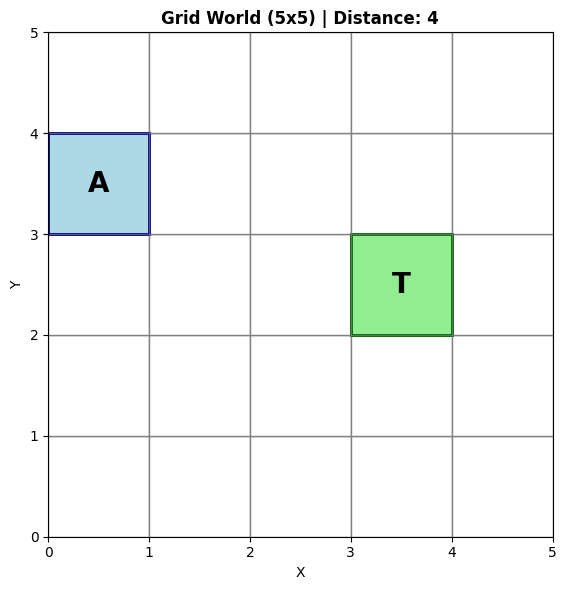

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output

def render_rgb(self):
    """
    使用 matplotlib 渲染网格（适合云端环境）
    返回 RGB 数组，可在 Jupyter 中显示
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # 设置坐标轴范围
    ax.set_xlim(0, self.size)
    ax.set_ylim(0, self.size)
    ax.set_aspect('equal')
    
    # 绘制网格线
    for i in range(self.size + 1):
        ax.axhline(i, color='gray', linewidth=0.5)
        ax.axvline(i, color='gray', linewidth=0.5)
    
    # 绘制所有空格子（浅灰色）
    for x in range(self.size):
        for y in range(self.size):
            rect = patches.Rectangle((x, y), 1, 1, 
                                     linewidth=1, 
                                     edgecolor='gray', 
                                     facecolor='white')
            ax.add_patch(rect)
    
    # 绘制目标（绿色）
    target_rect = patches.Rectangle(
        (self._target_location[0], self._target_location[1]), 1, 1,
        linewidth=2,
        edgecolor='darkgreen',
        facecolor='lightgreen'
    )
    ax.add_patch(target_rect)
    ax.text(self._target_location[0] + 0.5, self._target_location[1] + 0.5, 
            'T', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # 绘制智能体（蓝色）
    agent_rect = patches.Rectangle(
        (self._agent_location[0], self._agent_location[1]), 1, 1,
        linewidth=2,
        edgecolor='darkblue',
        facecolor='lightblue'
    )
    ax.add_patch(agent_rect)
    ax.text(self._agent_location[0] + 0.5, self._agent_location[1] + 0.5, 
            'A', ha='center', va='center', fontsize=20, fontweight='bold')
    
    # 设置标题和标签（使用英文避免中文显示问题）
    distance = np.linalg.norm(self._agent_location - self._target_location, ord=1)
    ax.set_title(f'Grid World ({self.size}x{self.size}) | Distance: {distance:.0f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # 添加坐标刻度
    ax.set_xticks(range(self.size + 1))
    ax.set_yticks(range(self.size + 1))
    
    plt.tight_layout()
    return fig

# 将方法添加到类中
SimpleGridWorldEnv.render_rgb = render_rgb

# 测试图形渲染
print("测试图形渲染")
print("=" * 60)

env = SimpleGridWorldEnv(size=5)
obs, info = env.reset(seed=42)

# 显示初始状态
fig = env.render_rgb()

# 在云端 Jupyter 环境中显示图片（使用 Agg 后端）
# 将 matplotlib figure 转换为图片并显示
buf = BytesIO()
fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
buf.seek(0)
plt.close(fig)

# 使用 IPython.display.Image 显示
print("\n显示初始网格状态:")
display(IPImage(buf.read()))

## 第四步：整合完整的环境类

现在让我们将所有代码整合成一个完整的、可重用的环境类：

In [7]:
class GridWorldEnv(gym.Env):
    """
    网格世界环境 - 完整版
    
    这是一个用于强化学习的标准网格世界环境，特别适合学习：
    - 贝尔曼最优公式
    - 值迭代算法
    - 策略迭代算法
    
    环境说明：
        - 网格大小可自定义 (size × size)
        - 智能体从随机位置开始
        - 目标在随机位置（不与智能体重合）
        - 智能体可以向四个方向移动：上、下、左、右
        - 到达边界时停在原地
        - 到达目标获得 +1 奖励，其他情况 0 奖励
    
    观察空间：
        Dict({
            "agent": Box(0, size-1, shape=(2,)),   # 智能体的 [x, y] 坐标
            "target": Box(0, size-1, shape=(2,)),  # 目标的 [x, y] 坐标
        })
    
    动作空间：
        Discrete(4):
            0 - 向右移动
            1 - 向上移动
            2 - 向左移动
            3 - 向下移动
    """
    
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    
    def __init__(
        self,
        size: Annotated[int, "网格的边长"] = 5,
        render_mode: Annotated[Optional[str], "渲染模式"] = None,
    ):
        """
        初始化网格世界环境
        
        参数：
            size: 网格的大小（默认 5×5）
            render_mode: 渲染模式 ("human" 或 "rgb_array")
        """
        super().__init__()
        
        self.size = size
        self.render_mode = render_mode
        
        # 定义观察空间
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
            "target": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
        })
        
        # 定义动作空间
        self.action_space = spaces.Discrete(4)
        
        # 动作到方向的映射（数学坐标系，y 轴向上）
        self._action_to_direction = {
            0: np.array([1, 0]),    # 右
            1: np.array([0, 1]),    # 上
            2: np.array([-1, 0]),   # 左
            3: np.array([0, -1]),   # 下
        }
        
        # 初始化位置
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
    
    def _get_obs(self) -> Annotated[Dict[str, np.ndarray], "当前观察字典"]:
        """返回当前观察"""
        return {
            "agent": self._agent_location.copy(),
            "target": self._target_location.copy()
        }
    
    def _get_info(self) -> Annotated[Dict[str, float], "额外信息字典"]:
        """返回额外信息（曼哈顿距离）"""
        return {
            "distance": float(np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            ))
        }
    
    def reset(
        self,
        seed: Annotated[Optional[int], "随机数种子"] = None,
        options: Annotated[Optional[dict], "额外选项"] = None,
    ) -> Annotated[Tuple[Dict[str, np.ndarray], Dict[str, float]], "初始观察和额外信息"]:
        """
        重置环境到初始状态
        
        参数：
            seed: 随机种子
            options: 额外选项
        
        返回：
            observation: 初始观察
            info: 额外信息
        """
        # 设置随机种子
        super().reset(seed=seed)
        
        # 随机放置智能体
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
        
        # 随机放置目标（确保不与智能体重合）
        self._target_location = self._agent_location.copy()
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
        
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, info
    
    def step(
        self,
        action: Annotated[int, "要执行的动作编号"],
    ) -> Annotated[Tuple[Dict[str, np.ndarray], float, bool, bool, Dict[str, float]], "新观察、奖励、终止标志、截断标志及额外信息"]:
        """
        执行一个动作
        
        参数：
            action: 要执行的动作 (0-3)
        
        返回：
            observation: 新观察
            reward: 奖励
            terminated: 是否终止
            truncated: 是否截断
            info: 额外信息
        """
        # 获取移动方向
        direction = self._action_to_direction[action]
        
        # 更新智能体位置（使用 clip 防止越界）
        self._agent_location = np.clip(
            self._agent_location + direction,
            0,
            self.size - 1
        )
        
        # 检查是否到达目标
        terminated = np.array_equal(self._agent_location, self._target_location)
        
        # 计算奖励
        reward = 1.0 if terminated else 0.0
        
        # 本环境不使用 truncated
        truncated = False
        
        observation = self._get_obs()
        info = self._get_info()
        
        return observation, reward, terminated, truncated, info
    
    def render(self):
        """渲染当前状态"""
        if self.render_mode == "human":
            self._render_text()
        elif self.render_mode == "rgb_array":
            return self._render_rgb()
    
    def _render_text(self):
        """文本模式渲染"""
        print("\\n" + "=" * (self.size * 2 + 1))
        for y in range(self.size - 1, -1, -1):
            row = "|"
            for x in range(self.size):
                if np.array_equal([x, y], self._agent_location):
                    row += "A "
                elif np.array_equal([x, y], self._target_location):
                    row += "T "
                else:
                    row += "· "
            print(row + "|")
        print("=" * (self.size * 2 + 1))
        print(f"智能体: {self._agent_location}, 目标: {self._target_location}, "
              f"距离: {self._get_info()['distance']:.0f}\\n")
    
    def _render_rgb(self):
        """图形模式渲染（返回 matplotlib figure）"""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_aspect('equal')
        
        # 绘制网格
        for i in range(self.size + 1):
            ax.axhline(i, color='gray', linewidth=0.5)
            ax.axvline(i, color='gray', linewidth=0.5)
        
        # 绘制格子
        for x in range(self.size):
            for y in range(self.size):
                rect = patches.Rectangle((x, y), 1, 1, 
                                         linewidth=1, edgecolor='gray', 
                                         facecolor='white')
                ax.add_patch(rect)
        
        # 绘制目标
        target_rect = patches.Rectangle(
            (self._target_location[0], self._target_location[1]), 1, 1,
            linewidth=2, edgecolor='darkgreen', facecolor='lightgreen'
        )
        ax.add_patch(target_rect)
        ax.text(self._target_location[0] + 0.5, self._target_location[1] + 0.5, 
                'T', ha='center', va='center', fontsize=20, fontweight='bold')
        
        # 绘制智能体
        agent_rect = patches.Rectangle(
            (self._agent_location[0], self._agent_location[1]), 1, 1,
            linewidth=2, edgecolor='darkblue', facecolor='lightblue'
        )
        ax.add_patch(agent_rect)
        ax.text(self._agent_location[0] + 0.5, self._agent_location[1] + 0.5, 
                'A', ha='center', va='center', fontsize=20, fontweight='bold')
        
        # 标题（使用英文避免中文显示问题）
        distance = self._get_info()['distance']
        ax.set_title(f'Grid World ({self.size}x{self.size}) | Distance: {distance:.0f}', 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks(range(self.size + 1))
        ax.set_yticks(range(self.size + 1))
        
        plt.tight_layout()
        return fig
    
    def close(self):
        """清理资源"""
        pass

print("✅ GridWorldEnv 类定义完成！")

✅ GridWorldEnv 类定义完成！


## 第五步：测试完整环境

让我们全面测试这个环境，确保它能正确工作：

In [8]:
# 创建环境实例
env = GridWorldEnv(size=5, render_mode="human")

print("=" * 60)
print("完整环境测试")
print("=" * 60)

# 重置环境
obs, info = env.reset(seed=42)
print(f"\\n初始观察: {obs}")
print(f"初始信息: {info}")
print("\\n初始状态:")
env.render()

# 模拟一个 episode
print("\\n开始交互（随机动作）:")
print("-" * 60)

for step in range(20):  # 最多 20 步
    # 随机选择一个动作
    action = env.action_space.sample()
    action_names = ['右', '上', '左', '下']
    
    # 执行动作
    obs, reward, terminated, truncated, info = env.step(action)
    
    print(f"\\n步骤 {step + 1}: 动作 = {action_names[action]}")
    env.render()
    print(f"奖励: {reward}, 终止: {terminated}")
    
    if terminated:
        print("\\n🎉 成功到达目标！")
        break

env.close()

完整环境测试
\n初始观察: {'agent': array([0, 3], dtype=int32), 'target': array([3, 2], dtype=int32)}
初始信息: {'distance': 4.0}
\n初始状态:
\n===========
|· · · · · |
|A · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体: [0 3], 目标: [3 2], 距离: 4\n
\n开始交互（随机动作）:
------------------------------------------------------------
\n步骤 1: 动作 = 左
\n===========
|· · · · · |
|A · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体: [0 3], 目标: [3 2], 距离: 4\n
奖励: 0.0, 终止: False
\n步骤 2: 动作 = 上
\n===========
|A · · · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体: [0 4], 目标: [3 2], 距离: 5\n
奖励: 0.0, 终止: False
\n步骤 3: 动作 = 上
\n===========
|A · · · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体: [0 4], 目标: [3 2], 距离: 5\n
奖励: 0.0, 终止: False
\n步骤 4: 动作 = 左
\n===========
|A · · · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体: [0 4], 目标: [3 2], 距离: 5\n
奖励: 0.0, 终止: False
\n步骤 5: 动作 = 上
\n===========
|A · · · · |
|· · · · · |
|· · · T · |
|· · · · · |
|· · · · · |
智能体: [0 4], 目标: [3 2],

## 第六步：使用 Gymnasium 的环境检查器验证

Gymnasium 提供了一个环境检查器，可以自动验证我们的环境是否符合标准：

In [66]:
from gymnasium.utils.env_checker import check_env

print("=" * 60)
print("使用 Gymnasium 环境检查器验证环境")
print("=" * 60)

env = GridWorldEnv(size=5)

try:
    check_env(env)
    print("\\n✅ 环境通过所有检查！")
    print("   - reset() 方法正确")
    print("   - step() 方法正确")
    print("   - 观察空间和动作空间定义正确")
    print("   - 随机种子功能正常")
except Exception as e:
    print(f"\\n❌ 环境检查失败: {e}")

env.close()

使用 Gymnasium 环境检查器验证环境
\n✅ 环境通过所有检查！
   - reset() 方法正确
   - step() 方法正确
   - 观察空间和动作空间定义正确
   - 随机种子功能正常


## 第七步：生成 GIF 动画（适合云端环境）

在云端环境中，我们可以将 episode 的过程保存为 GIF 动画，然后在 Jupyter 中直接查看：

In [ ]:
def render_to_array(
    env: Annotated[GridWorldEnv, "网格世界环境实例"],
) -> Annotated[np.ndarray, "用于生成动画的 RGB 数组"]:
    """
    将当前环境状态渲染为 numpy 数组（RGB 图像）
    
    参数：
        env: GridWorldEnv 实例
    
    返回：
        rgb_array: shape 为 (height, width, 3) 的 numpy 数组
    """
    # 创建图形，设置 DPI 以确保清晰度
    fig, ax = plt.subplots(figsize=(6, 6), dpi=80)
    ax.set_xlim(0, env.size)
    ax.set_ylim(0, env.size)
    ax.set_aspect('equal')
    
    # 绘制网格线
    for i in range(env.size + 1):
        ax.axhline(i, color='gray', linewidth=0.5)
        ax.axvline(i, color='gray', linewidth=0.5)
    
    # 绘制所有格子
    for x in range(env.size):
        for y in range(env.size):
            rect = patches.Rectangle((x, y), 1, 1, 
                                     linewidth=1, edgecolor='gray', 
                                     facecolor='white')
            ax.add_patch(rect)
    
    # 绘制目标（绿色）
    target_rect = patches.Rectangle(
        (env._target_location[0], env._target_location[1]), 1, 1,
        linewidth=2, edgecolor='darkgreen', facecolor='lightgreen'
    )
    ax.add_patch(target_rect)
    ax.text(env._target_location[0] + 0.5, env._target_location[1] + 0.5, 
            'T', ha='center', va='center', fontsize=20, fontweight='bold', color='darkgreen')
    
    # 绘制智能体（蓝色）
    agent_rect = patches.Rectangle(
        (env._agent_location[0], env._agent_location[1]), 1, 1,
        linewidth=2, edgecolor='darkblue', facecolor='lightblue'
    )
    ax.add_patch(agent_rect)
    ax.text(env._agent_location[0] + 0.5, env._agent_location[1] + 0.5, 
            'A', ha='center', va='center', fontsize=20, fontweight='bold', color='darkblue')
    
    # 设置标题（使用英文避免中文乱码问题）
    distance = np.linalg.norm(env._agent_location - env._target_location, ord=1)
    ax.set_title(f'Grid World ({env.size}x{env.size}) | Distance: {distance:.0f}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_xticks(range(env.size + 1))
    ax.set_yticks(range(env.size + 1))
    
    plt.tight_layout()
    
    # 将图形转换为 RGB 数组
    fig.canvas.draw()
    
    # 使用 buffer_rgba() 方法获取图像数据
    buf = fig.canvas.buffer_rgba()
    rgb_array = np.asarray(buf)
    
    # 转换 RGBA 到 RGB（去掉 alpha 通道）
    rgb_array = rgb_array[:, :, :3]
    
    plt.close(fig)
    
    return rgb_array


def create_episode_gif(
    env: Annotated[GridWorldEnv, "网格世界环境实例"],
    policy: Annotated[Optional[callable], "策略函数"] = None,
    max_steps: Annotated[int, "最大步数"] = 50,
    filename: Annotated[str, "保存的文件名"] = 'gridworld_episode.gif',
    fps: Annotated[int, "每秒帧数"] = 2,
    seed: Annotated[Optional[int], "随机种子"] = None,
) -> Annotated[Tuple[str, float, int], "保存的文件路径、episode总奖励及实际步数"]:
    """
    创建一个 episode 的 GIF 动画
    
    参数：
        env: GridWorldEnv 实例
        policy: 策略函数，输入 observation，输出 action。如果为 None，则使用随机策略
        max_steps: 最大步数
        filename: 保存的文件名
        fps: 每秒帧数
        seed: 随机种子
    
    返回：
        filename: 保存的文件路径
        total_reward: episode 总奖励
        steps: 实际步数
    """
    frames = []
    
    # 重置环境
    obs, info = env.reset(seed=seed)
    
    # 保存初始帧
    print(f"生成第 0 帧...")
    frames.append(render_to_array(env))
    
    total_reward = 0
    steps = 0
    
    # 运行 episode
    for step in range(max_steps):
        # 选择动作
        if policy is None:
            action = env.action_space.sample()  # 随机策略
        else:
            action = policy(obs)
        
        # 执行动作
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        
        # 保存帧
        print(f"生成第 {steps} 帧...")
        frames.append(render_to_array(env))
        
        if terminated or truncated:
            break
    
    # 保存为 GIF
    print(f"\n正在保存 GIF（共 {len(frames)} 帧）...")
    imageio.mimsave(filename, frames, fps=fps, loop=0)
    
    print(f"\n✅ GIF 动画已保存到: {filename}")
    print(f"   总步数: {steps}")
    print(f"   总奖励: {total_reward}")
    print(f"   是否成功: {'是' if terminated else '否'}")
    
    return filename, total_reward, steps


# 测试 GIF 生成功能
print("=" * 60)
print("测试 GIF 动画生成")
print("=" * 60)

env = GridWorldEnv(size=5)

# 生成一个随机策略的 episode
gif_file, reward, steps = create_episode_gif(
    env, 
    policy=None,  # 随机策略
    max_steps=50, 
    filename='gridworld_random.gif',
    fps=2,  # 每秒 2 帧
    seed=42
)

print(f"\n正在显示 GIF...")
# 在 Jupyter 中显示 GIF
display(IPImage(filename=gif_file))

### 示例：使用简单策略生成 GIF

我们可以定义一个简单的贪心策略（每次都朝目标方向移动），看看效果：

In [ ]:
def greedy_policy(
    obs: Annotated[Dict[str, np.ndarray], "观察字典，包含agent和target的位置"],
) -> Annotated[int, "选择的动作编号"]:
    """
    贪心策略：每次都朝目标方向移动
    
    参数：
        obs: 观察，包含 'agent' 和 'target' 的位置
    
    返回：
        action: 选择的动作 (0=右, 1=上, 2=左, 3=下)
    """
    agent_pos = obs['agent']
    target_pos = obs['target']
    
    # 计算差值
    dx = target_pos[0] - agent_pos[0]  # x 方向差值
    dy = target_pos[1] - agent_pos[1]  # y 方向差值
    
    # 优先移动距离更远的方向
    if abs(dx) > abs(dy):
        # x 方向距离更远
        if dx > 0:
            return 0  # 向右
        else:
            return 2  # 向左
    else:
        # y 方向距离更远（或相等）
        if dy > 0:
            return 1  # 向上
        else:
            return 3  # 向下


print("=" * 60)
print("使用贪心策略生成 GIF")
print("=" * 60)

env = GridWorldEnv(size=8)  # 使用更大的网格

# 生成贪心策略的 episode
gif_file, reward, steps = create_episode_gif(
    env, 
    policy=greedy_policy,  # 使用贪心策略
    max_steps=50, 
    filename='gridworld_greedy.gif',
    fps=3,  # 每秒 3 帧
    seed=123
)

# 在 Jupyter 中显示 GIF
display(IPImage(filename=gif_file))

print(f"\n💡 提示：贪心策略总能找到最短路径（曼哈顿距离）！")

## 📚 总结与下一步

### 🎯 你已经学会了：

1. **Gymnasium 的核心概念**
   - 观察空间 (Observation Space)
   - 动作空间 (Action Space)
   - 状态转移函数 (Transition Function)
   - 奖励函数 (Reward Function)

2. **如何创建自定义环境**
   - 继承 `gym.Env` 基类
   - 实现必需的方法：`__init__()`, `reset()`, `step()`
   - 添加可视化：文本渲染和图形渲染

3. **云端环境的可视化方案**
   - ✅ 文本渲染（ASCII 字符）
   - ✅ 静态图片（matplotlib）
   - ✅ **GIF 动画**（imageio + matplotlib）

4. **环境的测试与验证**
   - 使用 `check_env()` 验证环境符合标准
   - 通过交互测试环境行为

### 🔜 接下来可以做什么？

现在你已经有了一个标准的网格世界环境，可以用它来学习：

1. **贝尔曼最优公式**
   - 计算状态价值函数 V(s)
   - 计算动作价值函数 Q(s, a)

2. **值迭代算法**
   - 实现值迭代求解最优策略
   - 可视化值函数的收敛过程
   - 生成最优策略的 GIF 动画

3. **策略迭代算法**
   - 实现策略评估
   - 实现策略改进
   - 对比值迭代与策略迭代
   - 可视化策略改进过程

### 💡 环境的扩展方向

你可以根据需要扩展这个环境：

- **添加障碍物**：某些格子不可通过
- **添加陷阱**：踩到陷阱获得负奖励
- **不同的奖励函数**：
  - 每步给小的负奖励（鼓励最短路径）
  - 基于距离的奖励塑形
- **随机转移**：动作有一定概率失败（随机 MDP）
- **更大的网格**：测试算法的可扩展性

### 🎨 GIF 动画的使用场景

生成的 GIF 动画特别适合：
- 📊 **可视化学习过程**：观察智能体如何改进策略
- 📝 **写报告和论文**：展示算法效果
- 🎓 **教学演示**：直观展示强化学习概念
- 🐛 **调试策略**：发现策略的问题

---

**恭喜你完成了 Gymnasium 基础教程！现在你可以开始实现值迭代和策略迭代算法了。** 🎉